# **Multiarm Bandit Problem**


In this notebook I will go over different types of approches to solving Multiarm Bandit problem. Multiarm bandit problem assumes that we have a bandit with n arms. Each arms give a binary reward with unfiorm random probability p. They are simple form of single state MDP with unkown rewards and are considered online RL problems. Multiarm bandits are used in online advertising and recommendation systems to decide which ad, product, or content to show to a user to maximize clicks or purchases. We don’t know which ad will perform best in advances so we must explore new options but exploit known good ones. They have application in finance and clinical trials as well.

In [257]:
import random 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
seed = 27
random.seed(seed)
np.random.seed(seed)

## Bandit Initialization

Following cells contains a N‑armed `Bernoulli` bandit. Arm i returns binary reward`r ∈ {0,1}` with unknown probability `p_i`. The world is stationary and arms are independent. `Bandit.choose_action(i)` samples a binary reward using `p_i`.


In [258]:
random.seed(seed)
np.random.seed(seed)

class Bandit:
    def __init__(self, reward_probs):
        self.rewards = []
        self.reward_probs = np.array(reward_probs)
        self.num_arms = len(reward_probs)

    def choose_action(self, arm):
        prob = np.random.random()
        return  1 if prob < self.reward_probs[arm] else 0


## Simulator and policy overview

`Simulation` wraps the bandit and provides policies. `ε‑greedy` explores with `ε` else exploits the best mean. `Bayes‑UCB` takes the 95% posterior bound. `Thompson` samples from each `Beta` and picks the max. We explain before runs then analyze after. The detail of each policy are give before initialization


In [259]:
from scipy.stats import beta

random.seed(seed)
np.random.seed(seed)

class Simulation:

    def __init__(self, reward_probs, horizon):
        self.bandit = Bandit(reward_probs)
        self.horizon = horizon

    def run_random_simulation(self):
        actions = []
        reward_per_action = []
        cumulative_reward = []

        for pulls in range(self.horizon):
            action = np.random.randint(0, self.bandit.num_arms)
            reward = self.bandit.choose_action(action)

            actions.append(action)
            reward_per_action.append(reward)
            cumulative_reward.append(np.mean(reward_per_action))

        return {
            "actions": np.array(actions, dtype=int),
            "rewards": np.array(reward_per_action, dtype=int),
            "cum_reward": np.array(cumulative_reward, dtype=float)
        }
    

    def run_egreedy_simulation(self, epsilon):
        actions = []
        rewards = []
        cum_rewards = []
        avg_reward = {i: 0 for i in range(self.bandit.num_arms)}
        counts = {i: 0 for i in range(self.bandit.num_arms)}

        for pulls in range(self.horizon):
            if random.random() < epsilon:
                action = np.random.randint(0, self.bandit.num_arms)
            else:
                action = max(avg_reward, key=avg_reward.get)

            reward = self.bandit.choose_action(action)

            counts[action] += 1
            avg_reward[action] += (reward - avg_reward[action]) / counts[action] ## mean shortcut
            
            actions.append(action)
            rewards.append(reward)
            cum_rewards.append(np.mean(rewards))

        return {
            "actions": np.array(actions, dtype=int),
            "rewards": np.array(rewards, dtype=float),
            "cum_reward": np.array(cum_rewards, dtype=float)
        }
    
    def run_bayes_ucb_simulation(self , alpha):
        actions = []
        rewards = []
        cum_rewards = []
        count_wins_loss = {i:[1,1] for i in range(self.bandit.num_arms)}
        quantiles = [beta(a=alpha, b=alpha).ppf(0.95) for i in range(self.bandit.num_arms)]

        for pulls in range(self.horizon):
                action = np.argmax(quantiles)   
                reward = self.bandit.choose_action(action)
            
                if reward > 0: count_wins_loss[action][0]+=1 
                else: count_wins_loss[action][1]+=1

                quantiles[action] = beta(count_wins_loss[action][0], count_wins_loss[action][1]).ppf(0.95)
                
                
                actions.append(action)
                rewards.append(reward)
                cum_rewards.append(np.mean(rewards))


        return {
            "actions": np.array(actions, dtype=int),
            "rewards": np.array(rewards, dtype=float),
            "cum_reward": np.array(cum_rewards, dtype=float)
        }
    
    def run_thompson_sampling_ucb_simulation(self , alpha):
        actions = []
        rewards = []
        cum_rewards = []
        count_wins_loss = {i:[alpha,alpha] for i in range(self.bandit.num_arms)}

        for pulls in range(self.horizon):
                samples = [np.random.beta(count_wins_loss[i][0], count_wins_loss[i][1]) for i in range(self.bandit.num_arms)]
                action = np.argmax(samples)   
                reward = self.bandit.choose_action(action)
            
                if reward > 0: count_wins_loss[action][0]+=1 
                else: count_wins_loss[action][1]+=1

                actions.append(action)
                rewards.append(reward)
                cum_rewards.append(np.mean(rewards))


        return {
            "actions": np.array(actions, dtype=int),
            "rewards": np.array(rewards, dtype=float),
            "cum_reward": np.array(cum_rewards, dtype=float)
        }
            

        

### Visualization helpers


In [260]:
def plot_action_reward(history):

    actions = history["actions"]
    rewards = history["rewards"]
    cum_rewards = history["cum_reward"]
    steps = [i for i in range(len(actions))]

    figure = plt.figure(figsize=(30,10))
    
    ax1 = figure.add_subplot(121)
    ax1.plot(steps, cum_rewards)
    ax1.set_xlabel("Steps Taken")
    ax1.set_ylabel("Cumulative Reward")
    ax1.set_title("Cumulative Rewards")

    count = Counter(actions)
    arms = sorted(count.keys())
    values = [count[a] for a in arms]

    ax2 = figure.add_subplot(122)
    ax2.bar(arms, values)
    ax2.set_xlabel("Arms")
    ax2.set_ylabel("Count")
    ax2.set_title("Counts of Actions Taken")

    ax2.set_xticks(arms)
    ax2.set_xticklabels([str(a) for a in arms])
    for i, v in enumerate(values):
        ax2.text(arms[i], v + 0.1, str(v), ha='center') 

    plt.show()



def plot_multiple_histories(histories, horizons , alpha_values):

    mean_rewards_all_horizons = []

    for alpha_history in histories:
        mean_rewards_all_horizons.append([np.mean(alpha_history[i]["cum_reward"]) for i in range(len(horizons))])

    figure = plt.figure(figsize=(30, 10))
    ax1 = figure.add_subplot(121)   
    for i, alpha in enumerate(alpha_values):
        ax1.plot(horizons, mean_rewards_all_horizons[i], label=f"Alpha: {alpha}")

    ax1.set_xlabel("Horizon")
    ax1.set_ylabel("Average Reward")
    ax1.set_title("Average Reward over Time for Different Horizons and Alpha Values")
    ax1.legend()

    ax2 = figure.add_subplot(122)
    for i, horizon in enumerate(horizons):
        ax2.plot(alpha_values, [mean_rewards_all_horizons[j][i] for j in range(len(alpha_values))], label=f"Horizon: {horizon}")

    ax2.set_xlabel("Alpha Values")
    ax2.set_ylabel("Average Reward")
    ax2.set_title("Average Reward over Time for Different Alpha Values and Horizons")
    ax2.legend()


   
    plt.show()


def find_best_h_and_alpha(histories, horizons , alpha_values):

    best_avg_reward = -1
    best_horizon = None
    best_alpha = None

    for i, alpha_history in enumerate(histories):
        for j, history in enumerate(alpha_history):
            avg_reward = np.mean(history["cum_reward"])
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                best_horizon = horizons[j]
                best_alpha = alpha_values[i]

    return best_horizon, best_alpha, best_avg_reward

### Environment parameters

In [ ]:
random.seed(seed)
np.random.seed(seed)
n_arms = 3
horizon = 1000
reward_probs = np.random.random(n_arms)
print("Reward Probs: " , reward_probs)

Reward Probs:  [0.42572141 0.81458374 0.73539729]


## Random policy
Selects an arm uniformly at random at each step, without maintaining any estimates. Serves as a baseline to highlight the benefits of learning. Requires minimal computation and ensures unbiased exploration. Exhibits linear regret with no improvement over time, yielding near-uniform arm counts and an average reward close to the mean of `reward_probs`, typically below the best arm.


Mean Reward (Random Simulation): 0.6438434193711485


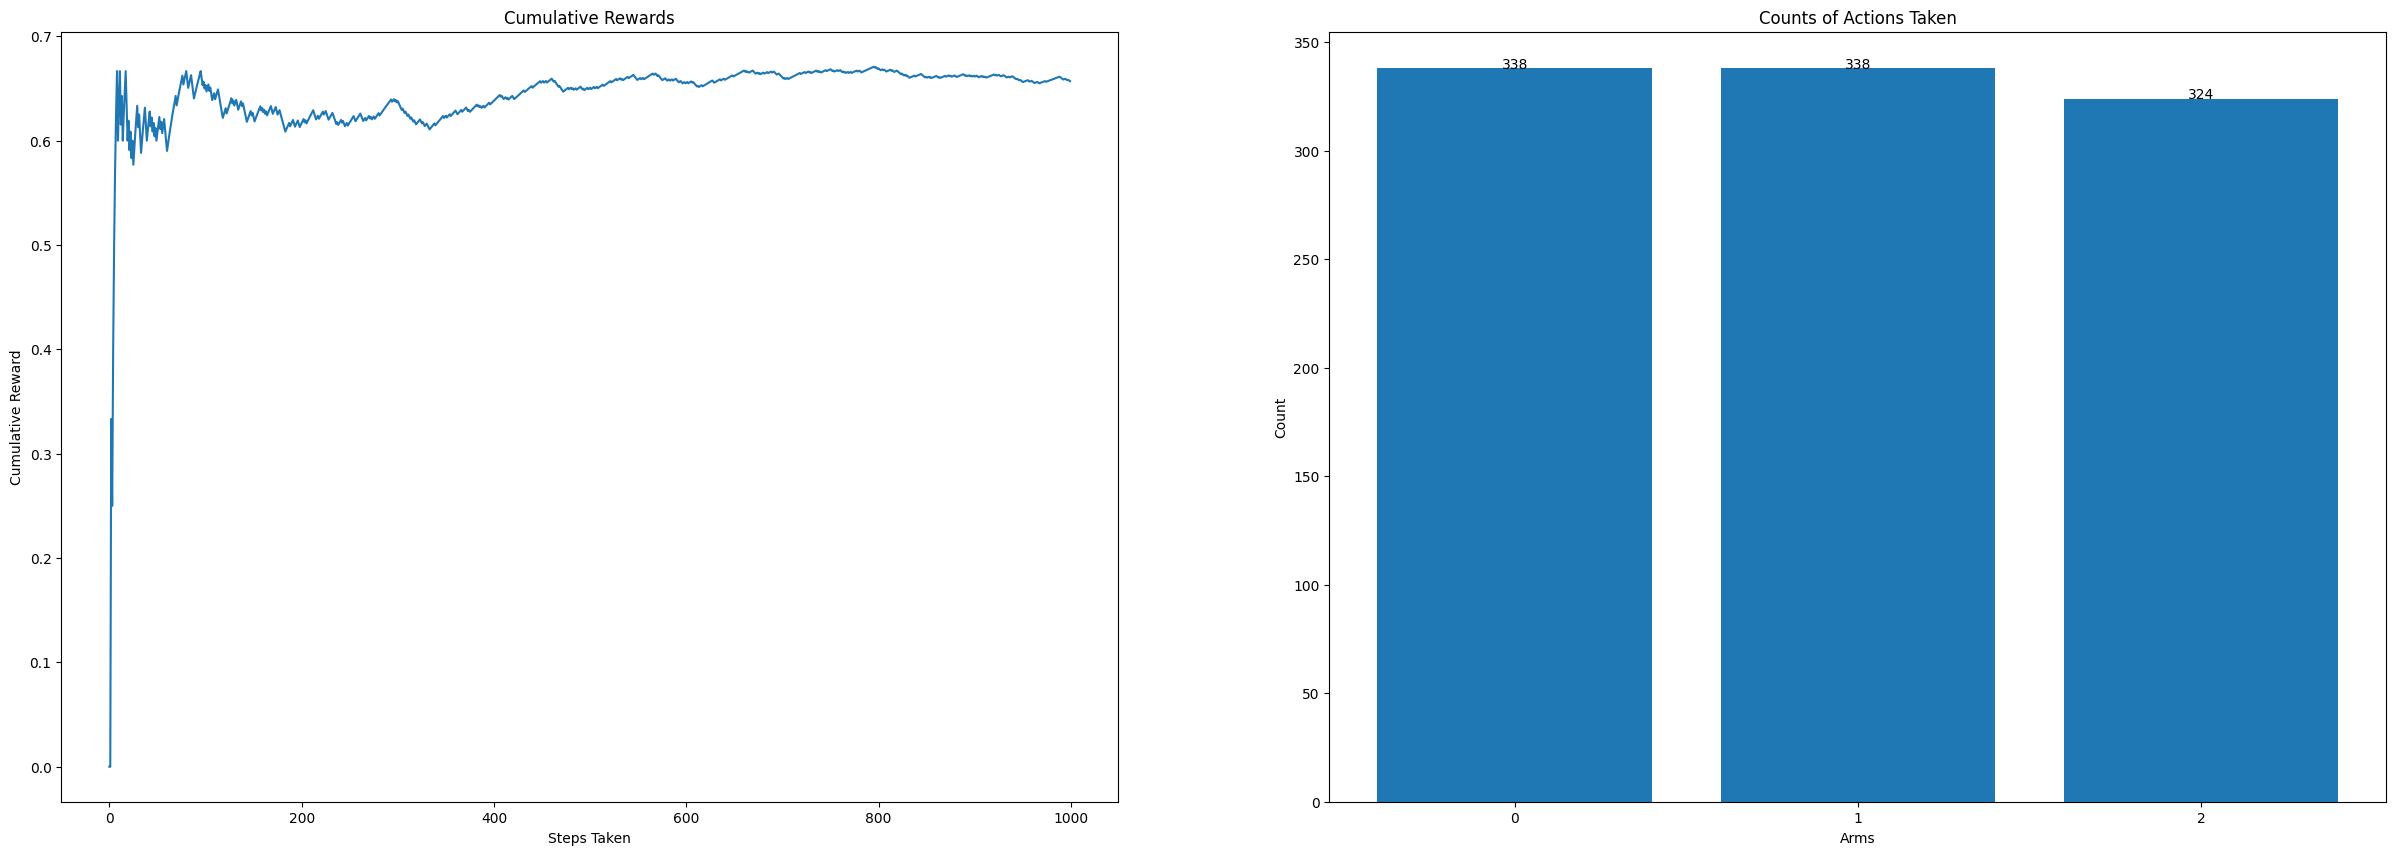

In [262]:
random.seed(seed)
np.random.seed(seed)
results = Simulation(reward_probs , horizon).run_random_simulation()
mean_reward = np.mean(results["cum_reward"]) 
print(f"Mean Reward (Random Simulation): {mean_reward}")
plot_action_reward(results)

## ε‑greedy 

At each step, with probability `ε` the policy explores a random arm; otherwise, it exploits by choosing the arm with the highest running mean. Here, we use `ε = 0.3`. Compared to a random policy, ε‑greedy is simple yet effective: it balances exploration and exploitation, focusing increasingly on the best arm over time. Its main limitation is sensitivity to `ε` a fixed value leads to persistent, non-zero regret. Overall, it produces a steadily rising cumulative reward curve and concentrates pulls on higher-reward arms.

As we can see mean reward beats random and moves toward the best arm. Counts show one dominant arm with some spill from exploration. The curve rises fast then plateaus below optimum with fixed `ε`. Try `ε = 1/t` for long horizons.


Mean Reward (Epsilon-Greedy Simulation): 0.7282436828570573


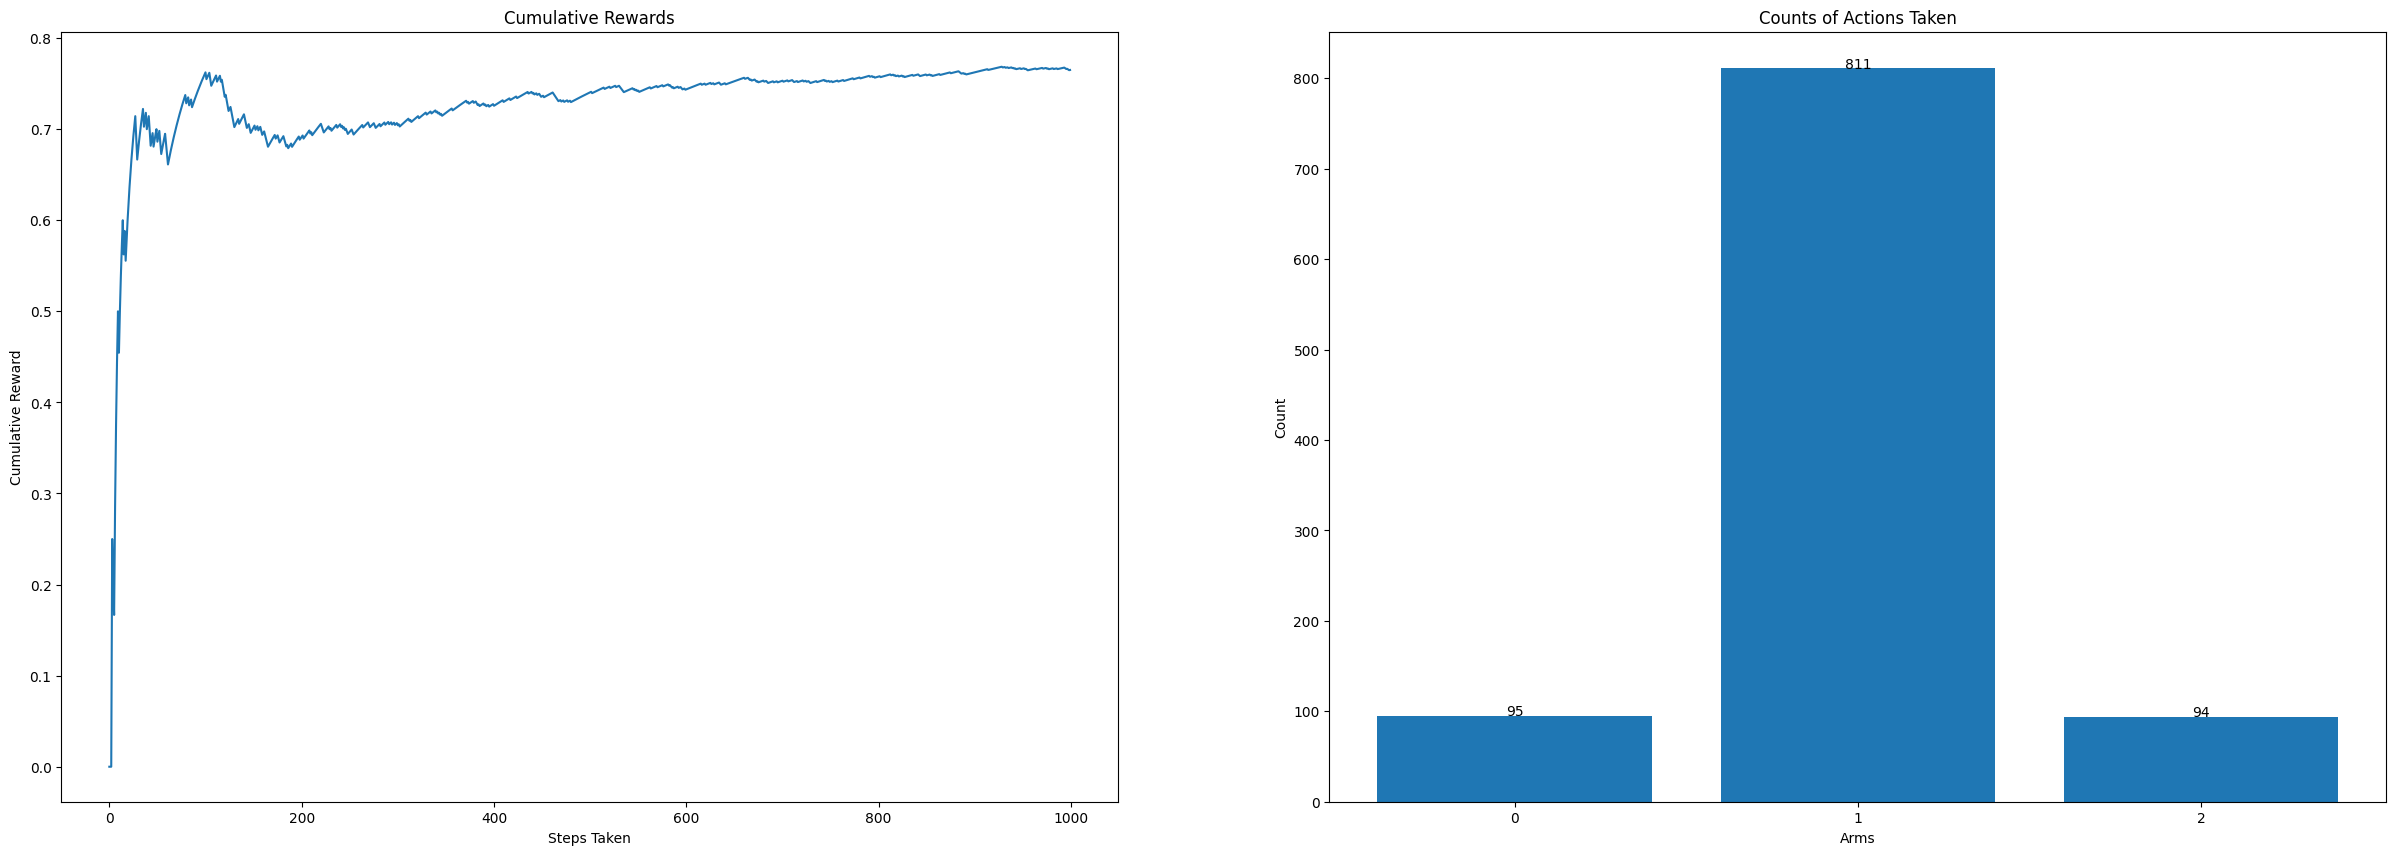

In [264]:
random.seed(seed)
np.random.seed(seed)
results = Simulation(reward_probs , horizon).run_egreedy_simulation(0.3)
mean_reward = np.mean(results["cum_reward"]) 
print(f"Mean Reward (Epsilon-Greedy Simulation): {mean_reward}")
plot_action_reward(results)

## Bayes‑UCB

Bayes‑UCB maintains a `Beta(α, α)` posterior for each arm and selects the arm with the 95% upper credible bound (`α = 1` here). By being optimistic, it quickly focuses on the best arm, often achieving higher mean rewards than ε‑greedy and performing well even in finite-time settings. However, it requires choosing a prior and a quantile, which can strongly influence performance. Early confidence can be misleading if `α` is too large or the quantile is overly aggressive, and the method has slightly more computational overhead compared to simpler strategies. Overall, Bayes‑UCB balances principled exploration with rapid convergence, but careful tuning is necessary to maximize its effectiveness.


As we can see, most pulls concentrate on the best arm, and the mean reward surpasses that of ε‑greedy. The cumulative reward climbs quickly and stabilizes near the optimal arm’s rate. 

Mean Reward (Bayes UCB Simulation): 0.7611024762925799


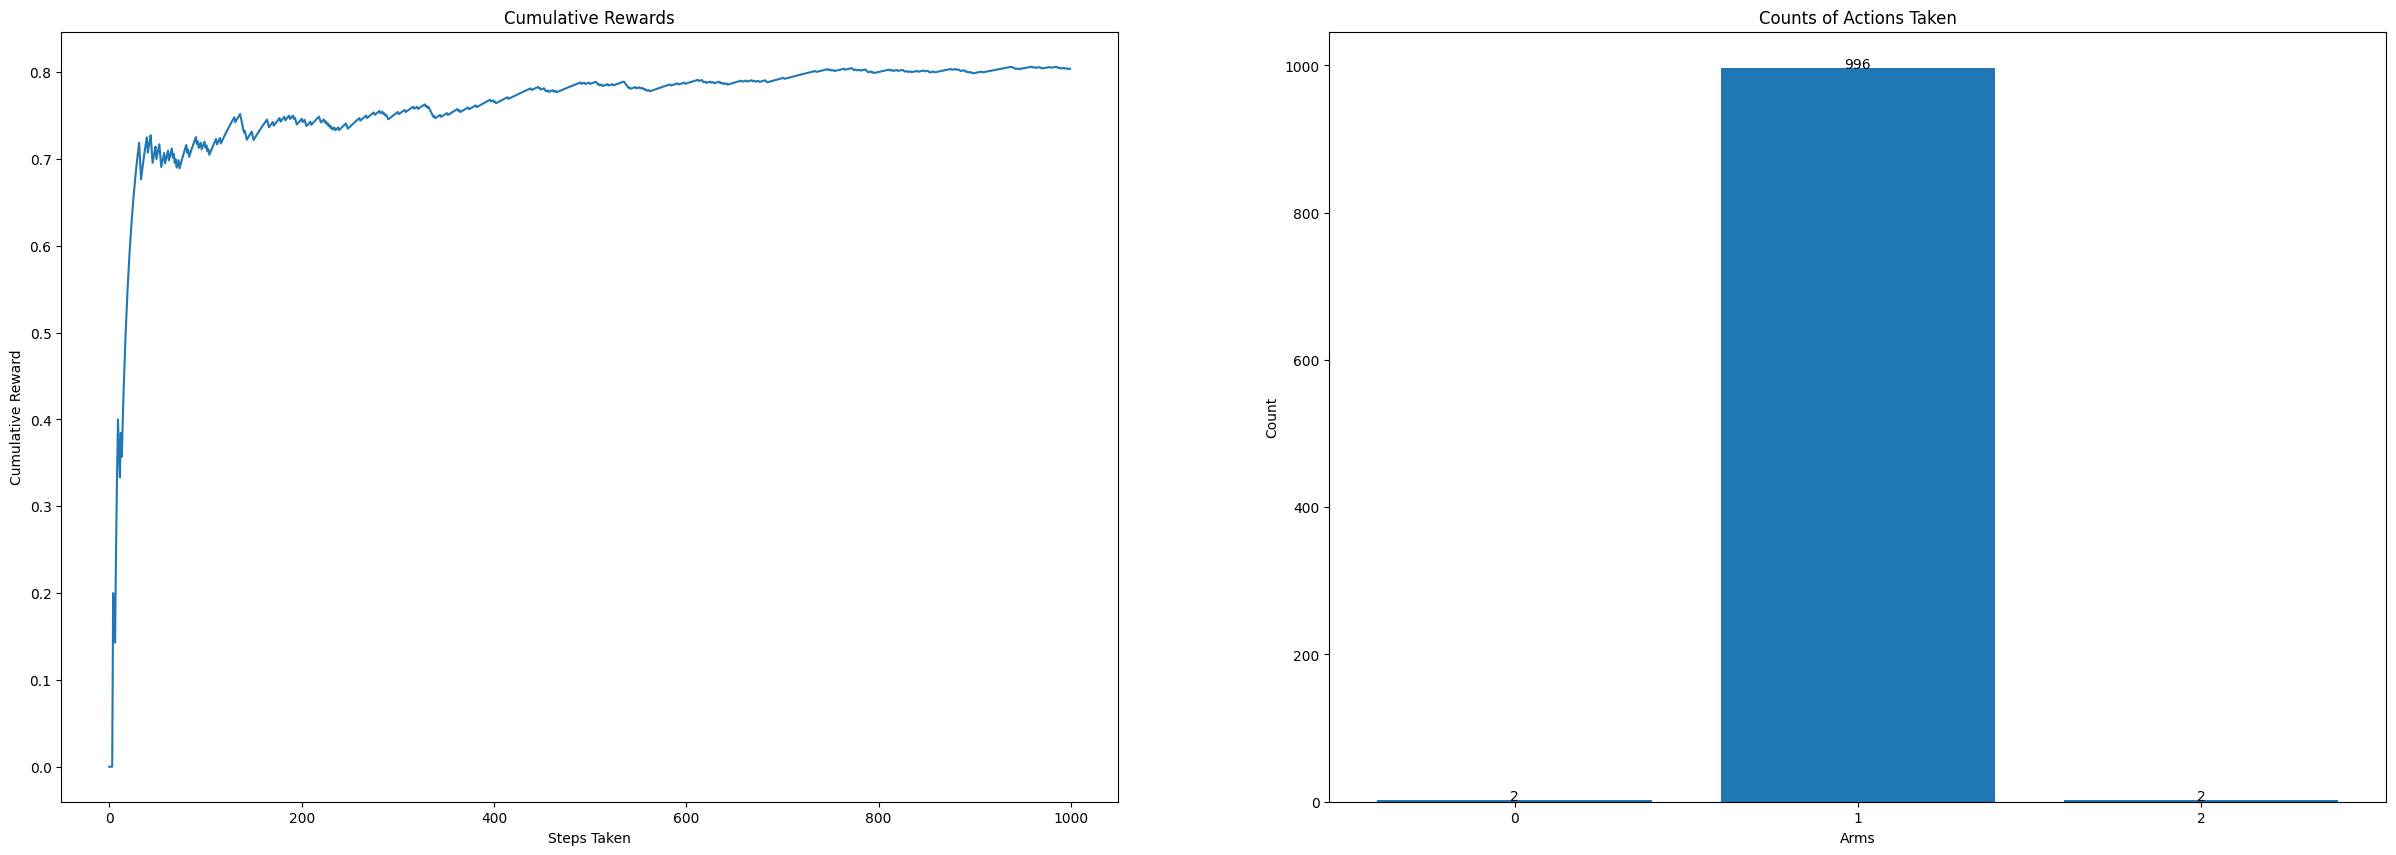

In [265]:
random.seed(seed)
np.random.seed(seed)
results = Simulation(reward_probs  , horizon).run_bayes_ucb_simulation(alpha=1)
mean_reward = np.mean(results["cum_reward"]) 
print(f"Mean Reward (Bayes UCB Simulation): {mean_reward}")
plot_action_reward(results)

## Bayes‑UCB sweep 

We perform a grid search over `α` in {1, 5, 10, 50, 100, 500, 1000} and `horizon` in {10, 100, 200, 500, 1000, 2500}, recording the average cumulative reward to study sensitivity to the prior and planning length. This helps identify a suitable `α`, though heavier computation and reliance on a single seed can be misleading. Typically, the best long-horizon performance is achieved at a moderate `α`.

For example, the best configuration here is `horizon` = 1000 and `α` = 10, yielding an average reward of 0.812. The console prints the best horizon and `α`. In the plots, the left panel shows reward versus horizon for each α, usually climbing before flattening near the optimal arm’s reward, while the right panel shows reward versus α for each `horizon`, short runs often favor smaller `α`, whereas long runs are generally flat for non-extreme `α`. Tiny-horizon wins should be treated with caution, as they may not generalize.


Best Horizon: 1000, Best Alpha: 10, Best Average Reward: 0.8122532003206804


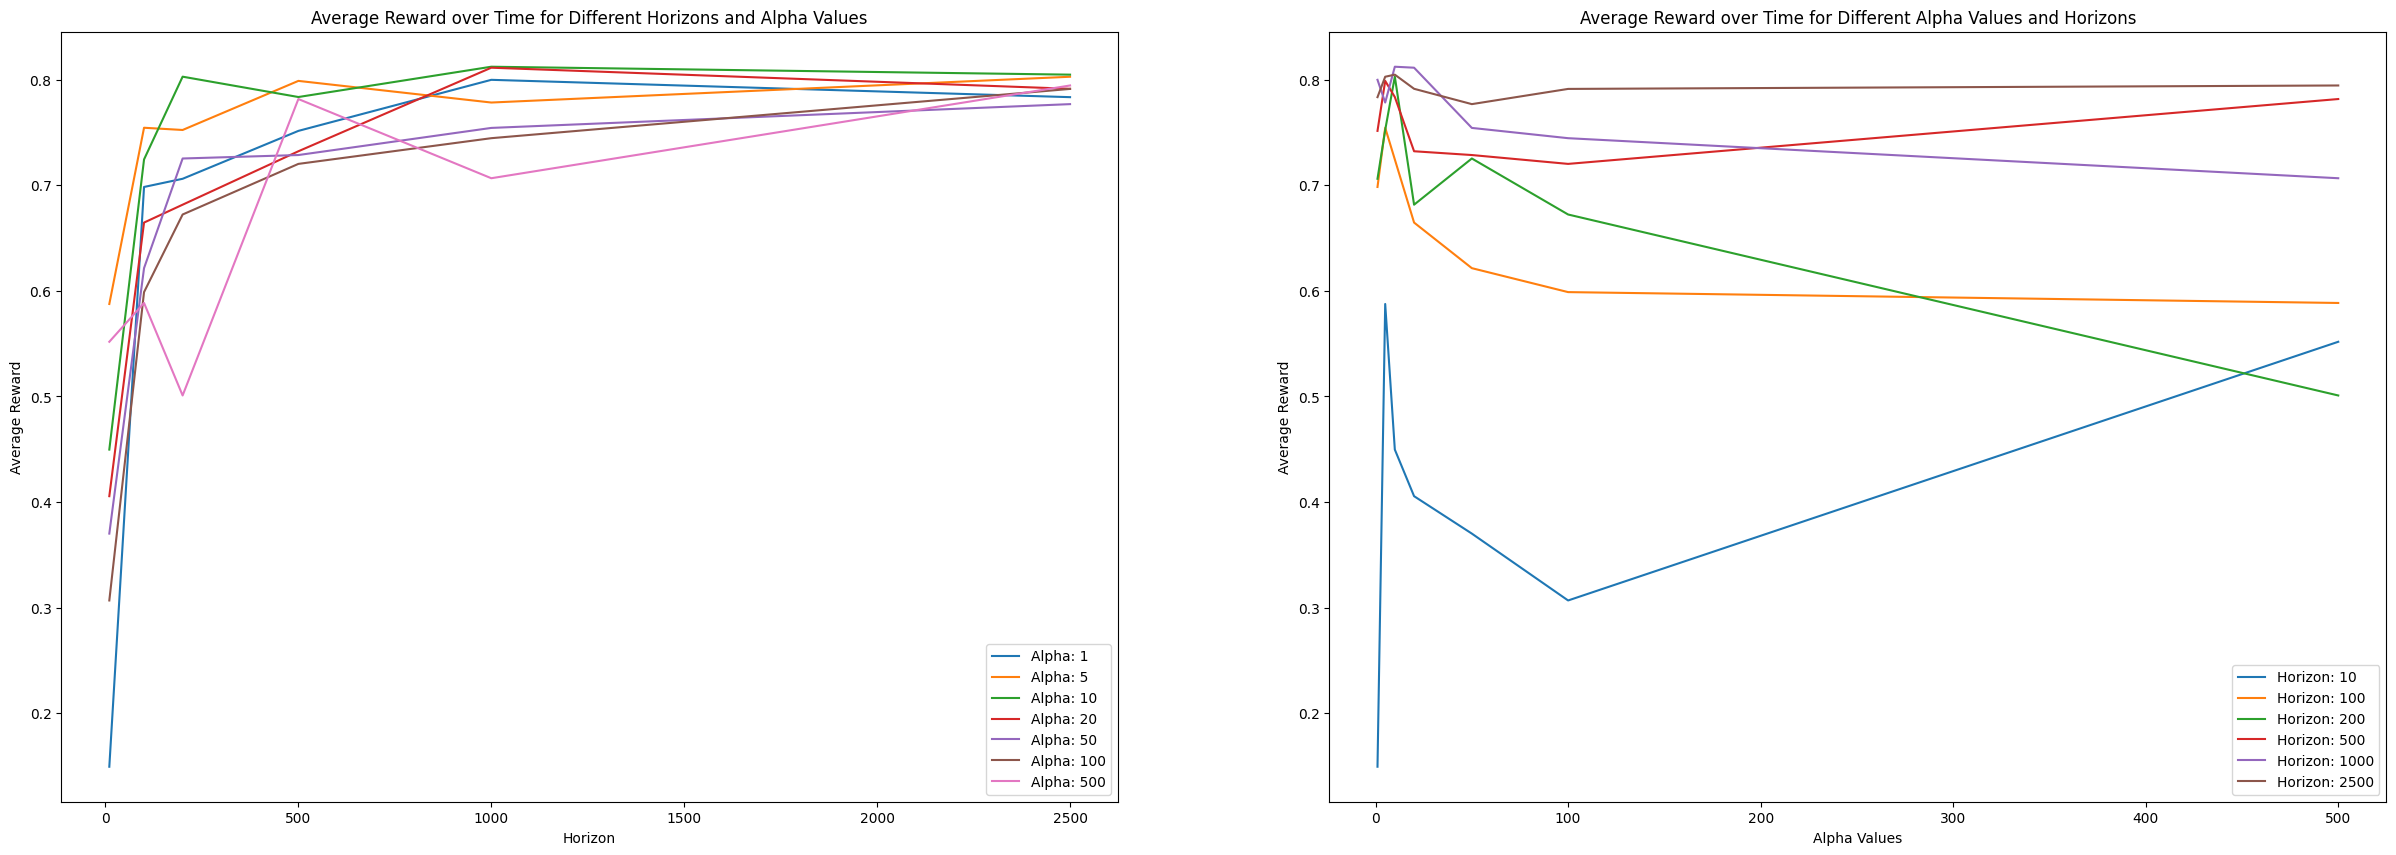

In [269]:
random.seed(seed)
np.random.seed(seed)
alphas  =  [1 , 5, 10 , 20 , 50 , 100 , 500]
horizons = [10, 100, 200, 500, 1000, 2500]
histories = []

for alpha in alphas:
    alpha_histories = []
    for h in horizons:
        history = Simulation(reward_probs , h).run_bayes_ucb_simulation(alpha)
        alpha_histories.append(history)
    histories.append(alpha_histories)


best_horizon, best_alpha, best_avg_reward = find_best_h_and_alpha(histories, horizons , alphas)
print(f"Best Horizon: {best_horizon}, Best Alpha: {best_alpha}, Best Average Reward: {best_avg_reward}")
plot_multiple_histories(histories , horizons , alphas)


## Thompson Sampling

Like Bayes‑UCB, Thompson Sampling maintains `Beta` posteriors for each arm, but at each step it samples `θ_i` from each posterior and selects the arm with the maximum sample. This approach is simple, requires minimal tuning, quickly focuses on high-reward arms, and performs well in the long run. However, its stochastic nature introduces variance in short runs, and it may occasionally favor suboptimal arms early.

Mean Reward (Thompson Sampling UCB Simulation): 0.798131200305465


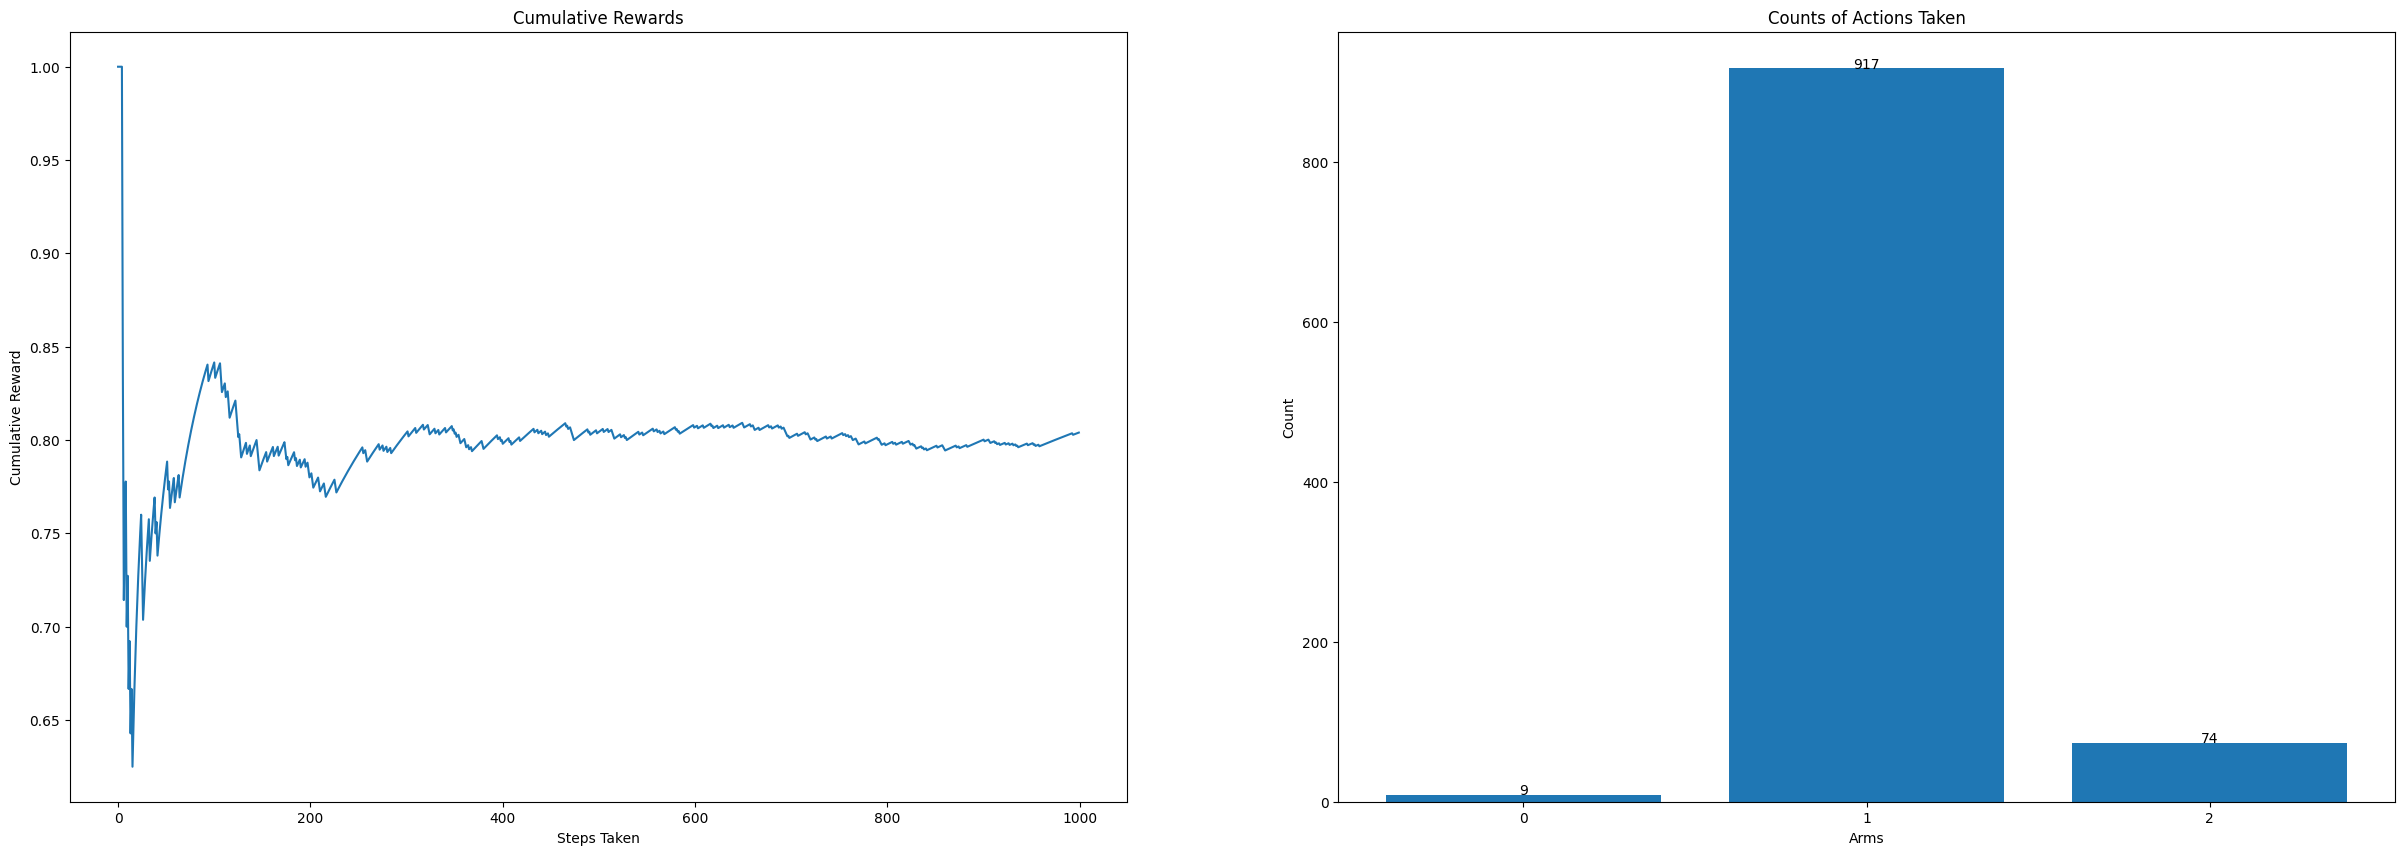

In [271]:
random.seed(seed)
np.random.seed(seed)
results = Simulation(reward_probs  , horizon).run_thompson_sampling_ucb_simulation(alpha = 1)
mean_reward = np.mean(results["cum_reward"]) 
print(f"Mean Reward (Thompson Sampling UCB Simulation): {mean_reward}")
plot_action_reward(results)

## Thompson Sampling Sweep 
Similar to bayes ucb we also perfom a sweep on thompson sampling, the best configuration is `horizon = 10` and `α = 1`, yielding an average reward of 0.878. Small-horizon wins can occur by chance, so it is important to inspect reward curves for stability, and for noisy results, averaging over multiple seeds is recommended. Over long horizons, Thompson Sampling approaches Bayes‑UCB in performance and consistently favors the optimal arm. Its simplicity and minimal tuning requirements make it a strong default choice when you want to avoid selecting a quantile.


Best Horizon: 10, Best Alpha: 1, Best Average Reward: 0.8775396825396825


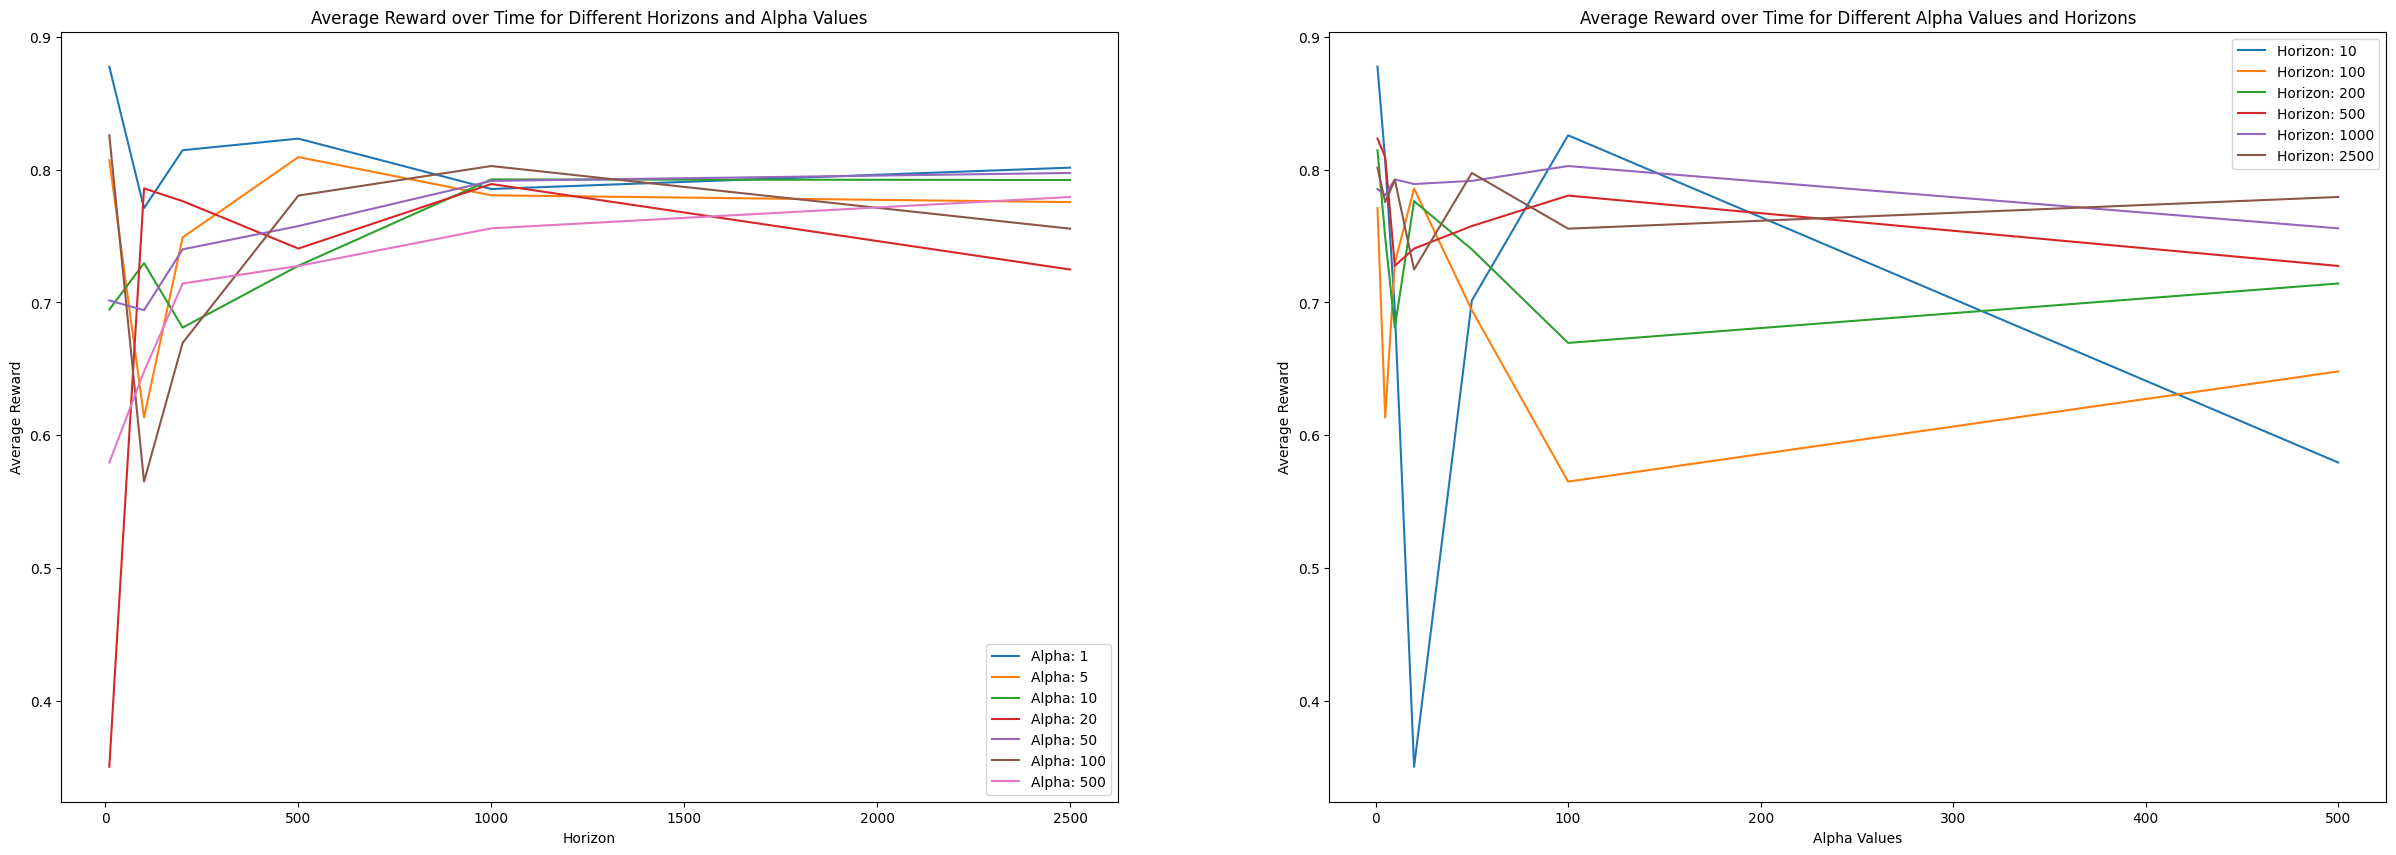

In [270]:
random.seed(seed)
np.random.seed(seed)
alphas  =  [1 , 5, 10 , 20 , 50 , 100 , 500]
horizons = [10, 100, 200, 500, 1000, 2500]
histories = []

for alpha in alphas:
    alpha_histories = []
    for h in horizons:
        history = Simulation(reward_probs , h).run_thompson_sampling_ucb_simulation(alpha)
        alpha_histories.append(history)
    histories.append(alpha_histories)


best_horizon, best_alpha, best_avg_reward = find_best_h_and_alpha(histories, horizons , alphas)
print(f"Best Horizon: {best_horizon}, Best Alpha: {best_alpha}, Best Average Reward: {best_avg_reward}")
plot_multiple_histories(histories , horizons , alphas)